# Multi-label classification of music into emotions

## Abstract
In this notebook, I will discuss the results of my first assignment of the class Introduction to Artificial Intelligence. My job was to implement an automatic emotion detector in music from a pre-determined dataset. Finally, I will discuss my results and present some insights into the data.

## Introduction

Music, as any piece of art, affects our emotions. As music databases expand the necessity of emotion detection into music increases. It can be used for recommendation systems, music selection, and even music therapy.

However, one music can express more than one emotion at the same time. A retro wave song of the 80s can cause confusion and happiness for some people. To represent multiple classifications the dataset used for this task is structured with One-Hot-Encoded labels. That describes our assignment as a Multi-label Classification problem.

## Dataset

This dataset is available at: https://bit.ly/2XaEyMt

### About the Data:
This dataset contains 593 different songs.

1. Rhythmic Features: The rhythmic features were derived by extracting periodic changes from a beat histogram. An algorithm that identifies peaks using autocorrelation was implemented by the authors. They selected the two highest peaks and computed their amplitudes,their BMPs (beats per minute) and the high-to-low ratio of their BPMs. In addition, 3 features were calculated by summing the histogram bins between 40-90, 90-140 and 140-250 BPMs respectively. The whole process led to a total of 8 rhythmic features.
<br/>
<br/>
2. Timbre Features: Mel Frequency Cepstral Coefficients (MFCCs) are used for speech recognition and music modeling. To derive MFCCs features, the signal was divided into frames and the amplitude spectrum was calculated for each frame. Next, its logarithm was taken and converted to Mel scale. Finally, the discrete cosine transform was implemented. They selected the first 13 MFCCs. Another set of 3 features that relate to timbre textures were extracted from the Short-Term Fourier Transform (FFT): *Spectral centroid, spectral rolloff and spectral flux*. For each of the 16 aforementioned features (13 MFCCs, 3 FFT) they calculated the mean, standard deviation (std), mean standard deviation (mean std) and standard deviation of standard deviation (std std) over all frames. This led to a total of 64 timbre features.
<br/>
<br/>
3. Emotion Labels: These are the targets of the classification, there are 6 classes designed so that a song can represent more than one emotion. So making the problem a Multi-Label one.

The paper related to the production of this dataset is available at: https://ismir2008.ismir.net/papers/ISMIR2008_275.pdf

## Imports

In [1]:
%load_ext tensorboard
# Data Preprocessing Packages
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import re
from scipy.io.arff import loadarff

# Data Visualization Packages
import matplotlib.pyplot as plt
import seaborn as sns

# ML Packages
from sklearn import model_selection, svm
from sklearn.svm import SVR
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, StratifiedKFold, KFold, RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import xgboost as xgb
import time
import tensorflow as tf

gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)
    
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPool1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from imblearn.over_sampling import RandomOverSampler
from sklearn.naive_bayes import GaussianNB
from skmultilearn.ensemble import RakelD
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.utils import class_weight
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.metrics import multilabel_confusion_matrix,ConfusionMatrixDisplay, f1_score
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization
from sklearn import metrics

## Acquiring Dataset

In [2]:
df = pd.read_csv('multilabel-classification-emotions/emotions.csv', encoding = 'utf-8')
df.drop(columns = ['Unnamed: 0'],inplace = True)
df.head()

,Mean_Acc1298_Mean_Mem40_Centroid,Mean_Acc1298_Mean_Mem40_Rolloff,Mean_Acc1298_Mean_Mem40_Flux,Mean_Acc1298_Mean_Mem40_MFCC_0,Mean_Acc1298_Mean_Mem40_MFCC_1,Mean_Acc1298_Mean_Mem40_MFCC_2,Mean_Acc1298_Mean_Mem40_MFCC_3,Mean_Acc1298_Mean_Mem40_MFCC_4,Mean_Acc1298_Mean_Mem40_MFCC_5,Mean_Acc1298_Mean_Mem40_MFCC_6,...,BH_HighLowRatio,BHSUM1,BHSUM2,BHSUM3,amazed-suprised,happy-pleased,relaxing-calm,quiet-still,sad-lonely,angry-aggresive
0,0.034741,0.089665,0.091225,-73.302422,6.215179,0.615074,2.037160,0.804065,1.301409,0.558576,...,2.0,0.245457,0.105065,0.405399,0.0,1.0,1.0,0.0,0.0,0.0
1,0.081374,0.272747,0.085733,-62.584437,3.183163,-0.218145,0.163038,0.620251,0.458514,0.041426,...,2.0,0.343547,0.276366,0.710924,1.0,0.0,0.0,0.0,0.0,1.0
2,0.110545,0.273567,0.084410,-65.235325,2.794964,0.639047,1.281297,0.757896,0.489412,0.627636,...,3.0,0.188693,0.045941,0.457372,0.0,1.0,0.0,0.0,0.0,1.0
3,0.042481,0.199281,0.093447,-80.305152,5.824409,0.648848,1.754870,1.495532,0.739909,0.809644,...,2.0,0.102839,0.241934,0.351009,0.0,0.0,1.0,0.0,0.0,0.0
4,0.074550,0.140880,0.079789,-93.697749,5.543229,1.064262,0.899152,0.890336,0.702328,0.490685,...,2.0,0.195196,0.310801,0.683817,0.0,0.0,0.0,1.0,0.0,0.0


In [3]:
df.info() #Acquiring basic information of each columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593 entries, 0 to 592
Data columns (total 78 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Mean_Acc1298_Mean_Mem40_Centroid  593 non-null    float64
 1   Mean_Acc1298_Mean_Mem40_Rolloff   593 non-null    float64
 2   Mean_Acc1298_Mean_Mem40_Flux      593 non-null    float64
 3   Mean_Acc1298_Mean_Mem40_MFCC_0    593 non-null    float64
 4   Mean_Acc1298_Mean_Mem40_MFCC_1    593 non-null    float64
 5   Mean_Acc1298_Mean_Mem40_MFCC_2    593 non-null    float64
 6   Mean_Acc1298_Mean_Mem40_MFCC_3    593 non-null    float64
 7   Mean_Acc1298_Mean_Mem40_MFCC_4    593 non-null    float64
 8   Mean_Acc1298_Mean_Mem40_MFCC_5    593 non-null    float64
 9   Mean_Acc1298_Mean_Mem40_MFCC_6    593 non-null    float64
 10  Mean_Acc1298_Mean_Mem40_MFCC_7    593 non-null    float64
 11  Mean_Acc1298_Mean_Mem40_MFCC_8    593 non-null    float64
 12  Mean_Acc

In [4]:
df.describe()

,Mean_Acc1298_Mean_Mem40_Centroid,Mean_Acc1298_Mean_Mem40_Rolloff,Mean_Acc1298_Mean_Mem40_Flux,Mean_Acc1298_Mean_Mem40_MFCC_0,Mean_Acc1298_Mean_Mem40_MFCC_1,Mean_Acc1298_Mean_Mem40_MFCC_2,Mean_Acc1298_Mean_Mem40_MFCC_3,Mean_Acc1298_Mean_Mem40_MFCC_4,Mean_Acc1298_Mean_Mem40_MFCC_5,Mean_Acc1298_Mean_Mem40_MFCC_6,...,BH_HighLowRatio,BHSUM1,BHSUM2,BHSUM3,amazed-suprised,happy-pleased,relaxing-calm,quiet-still,sad-lonely,angry-aggresive
count,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,...,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000
mean,0.069309,0.195399,0.085695,-72.998228,4.979178,0.602395,1.694625,0.634156,0.833964,0.508060,...,2.099494,0.412940,0.354901,0.959906,0.291737,0.279933,0.445194,0.249578,0.283305,0.318718
std,0.031293,0.117605,0.009260,7.580804,2.071792,1.017603,0.606581,0.448746,0.368312,0.303277,...,0.316040,0.339559,0.362262,0.651827,0.454946,0.449345,0.497407,0.433134,0.450984,0.466373
min,0.010201,0.038286,0.070932,-99.090802,0.051474,-2.277307,-0.604609,-1.143864,-0.237114,-0.444623,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.044781,0.107742,0.079018,-77.078349,3.409922,-0.113441,1.307242,0.373195,0.605057,0.309033,...,2.000000,0.179411,0.099424,0.513974,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.065251,0.169757,0.083637,-72.474302,4.642338,0.588380,1.731031,0.618838,0.819652,0.534665,...,2.000000,0.309902,0.246193,0.804229,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.086290,0.257668,0.091323,-68.292848,6.439446,1.293202,2.072488,0.925091,1.051206,0.708430,...,2.000000,0.529859,0.472593,1.242089,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,0.195412,0.698277,0.159460,-56.297652,12.069754,3.910873,4.382370,2.252710,2.358098,1.484489,...,3.000000,1.795128,1.797765,3.422899,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Exploratory Data Analysis:

The first observations to be made with this information are :

1. There is no missing data, but that does not deny the hypothesis that there may be inconsistent information.
2. There are **many** attributes in this dataset, most likely some of these are correlated.
3. This is a multilabel classification problem, the distribution of classes will have to be analyzed in detail to avoid imbalanced data.

### Analysis of the distribution of classes:

1. I will split the dataset into Classes and Attributes, and analyze the Classes separately;
2. Next, I will analyze the distribution of the classes;
3. Then a detailed analysis of each combination will be made in the dataset.

In [5]:
labels = ['amazed-suprised', 'happy-pleased', 'relaxing-calm', 'quiet-still', 'sad-lonely', 'angry-aggresive']

feats_df = df.drop(columns = labels)
labels_df = df[labels]

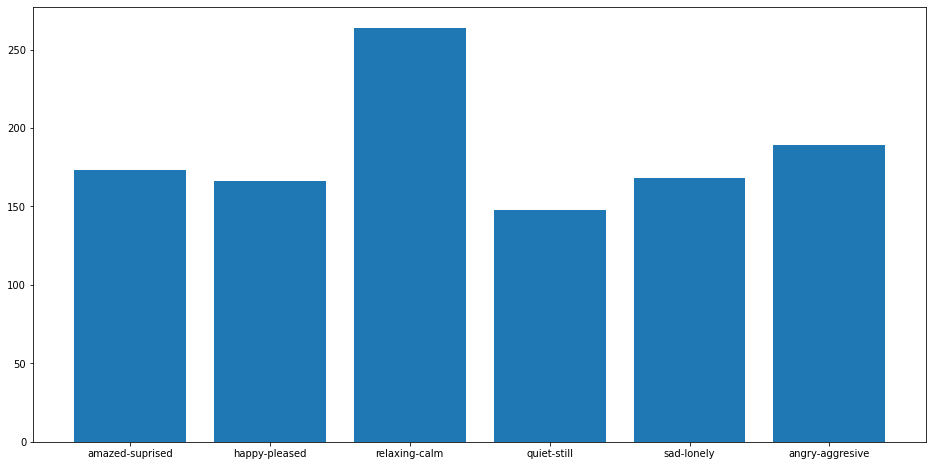

In [6]:
label_d = {'amazed-suprised' : 0, 'happy-pleased': 0, 'relaxing-calm' : 0, 'quiet-still' : 0, 'sad-lonely': 0, 'angry-aggresive' : 0}
for col in labels_df.columns:
    label_d[col] += len(labels_df[labels_df[col] == 1])

plt.figure(figsize = (16,8))
plt.bar(range(len(label_d)), list(label_d.values()), align='center')
plt.xticks(range(len(label_d)), list(label_d.keys()))
plt.show()

From this graph, it is possible to observe an imbalance between classes. Many songs convey relaxing-calm, and few represent quiet-still.

In [7]:
def transform_multiclass(orig_df):
    df = orig_df.copy()
    classe = []
    for i in range(len(df)):
        classe.append('')
    
    for i in range(len(df)):
        if df['amazed-suprised'][i] == 1:
            classe[i] = classe[i] + 'surprised-'
        if df['happy-pleased'][i] == 1:
            classe[i] = classe[i] + 'happy-'
        if df['relaxing-calm'][i] == 1:
            classe[i] = classe[i] + 'relaxing-'
        if df['quiet-still'][i] == 1:
            classe[i] = classe[i] + 'still-'
        if df['sad-lonely'][i] == 1:
            classe[i] = classe[i] + 'lonely-'
        if df['angry-aggresive'][i] == 1:
            classe[i] = classe[i] + 'angry-'
            
    df['Class'] = classe
    df.drop(['angry-aggresive','amazed-suprised','happy-pleased','relaxing-calm','quiet-still','sad-lonely'],axis=1,inplace = True)
    return df

In [8]:
class_label_df = transform_multiclass(labels_df)
class_label_df['Class'].unique()

array(['happy-relaxing-', 'surprised-angry-', 'happy-angry-', 'relaxing-',
       'still-', 'surprised-happy-', 'angry-', 'relaxing-still-lonely-',
       'surprised-', 'relaxing-lonely-', 'lonely-', 'lonely-angry-',
       'happy-', 'relaxing-angry-', 'surprised-happy-angry-',
       'relaxing-still-', 'surprised-lonely-', 'relaxing-lonely-angry-',
       'happy-lonely-', 'surprised-happy-relaxing-',
       'surprised-relaxing-', 'happy-relaxing-still-', 'still-lonely-',
       'happy-still-', 'relaxing-still-angry-', 'still-lonely-angry-',
       'surprised-lonely-angry-'], dtype=object)

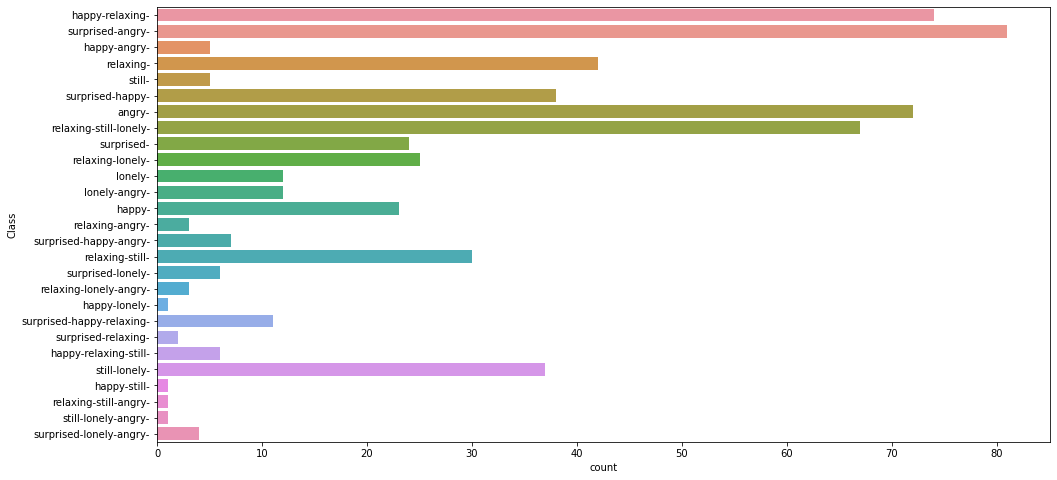

surprised-angry-             81
happy-relaxing-              74
angry-                       72
relaxing-still-lonely-       67
relaxing-                    42
surprised-happy-             38
still-lonely-                37
relaxing-still-              30
relaxing-lonely-             25
surprised-                   24
happy-                       23
lonely-                      12
lonely-angry-                12
surprised-happy-relaxing-    11
surprised-happy-angry-        7
happy-relaxing-still-         6
surprised-lonely-             6
happy-angry-                  5
still-                        5
surprised-lonely-angry-       4
relaxing-angry-               3
relaxing-lonely-angry-        3
surprised-relaxing-           2
relaxing-still-angry-         1
happy-lonely-                 1
happy-still-                  1
still-lonely-angry-           1
Name: Class, dtype: int64

In [9]:
plt.figure(figsize = (16,8))
sns.countplot(y = class_label_df.Class)
plt.show()
class_label_df.Class.value_counts()

Analyzing each combination of classes present in the dataset, it is possible to notice an imbalance in the labels. In order to solve this problem, I will remove the classes that have less than five songs. Then, I will make a RandomOverSample.

### Data Correlation

In [10]:
df.corr().style.background_gradient(cmap='coolwarm')

With the correlation matrix above it is possible to observe that many attributes have a correlation rate greater than 0.8. I will remove these columns to reduce the dimensionality and repetition of information in the dataset.

### Duplicated and Missing Data

In [11]:
df.duplicated().unique()

array([False])

There is no duplicated record

In [12]:
df.isnull().sum().unique()

array([0])

There is no null data

## Data Cleaning:

### Removing highly correlated features:

In [13]:
# Correlational Matrix
corr_matrix = feats_df.corr().abs()

# Selects Upper section of the matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Finds column with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

#Remove highly correlated features
df.drop(df[to_drop], axis=1,inplace = True)

### Handling the imbalance:
As the classes are unbalanced, I will use the RandomOverSampler oversampling technique. I will perform tests without using oversampling too, and I will select the method that obtains the best result.

Adicionando label com a classe de cada música

In [14]:
df['Class'] = class_label_df['Class']
df.head()

,Mean_Acc1298_Mean_Mem40_Centroid,Mean_Acc1298_Mean_Mem40_Rolloff,Mean_Acc1298_Mean_Mem40_Flux,Mean_Acc1298_Mean_Mem40_MFCC_0,Mean_Acc1298_Mean_Mem40_MFCC_1,Mean_Acc1298_Mean_Mem40_MFCC_2,Mean_Acc1298_Mean_Mem40_MFCC_3,Mean_Acc1298_Mean_Mem40_MFCC_4,Mean_Acc1298_Mean_Mem40_MFCC_5,Mean_Acc1298_Mean_Mem40_MFCC_6,...,BH_LowPeakBPM,BH_HighPeakBPM,BH_HighLowRatio,amazed-suprised,happy-pleased,relaxing-calm,quiet-still,sad-lonely,angry-aggresive,Class
0,0.034741,0.089665,0.091225,-73.302422,6.215179,0.615074,2.037160,0.804065,1.301409,0.558576,...,68.0,136.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,happy-relaxing-
1,0.081374,0.272747,0.085733,-62.584437,3.183163,-0.218145,0.163038,0.620251,0.458514,0.041426,...,70.0,140.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,surprised-angry-
2,0.110545,0.273567,0.084410,-65.235325,2.794964,0.639047,1.281297,0.757896,0.489412,0.627636,...,61.0,183.0,3.0,0.0,1.0,0.0,0.0,0.0,1.0,happy-angry-
3,0.042481,0.199281,0.093447,-80.305152,5.824409,0.648848,1.754870,1.495532,0.739909,0.809644,...,66.0,132.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,relaxing-
4,0.074550,0.140880,0.079789,-93.697749,5.543229,1.064262,0.899152,0.890336,0.702328,0.490685,...,100.0,200.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,still-


Creating new dataframe without the older labels.

In [15]:
class_df = df.drop(labels,1)
print(class_df.shape)
class_df.head()

(593, 54)


,Mean_Acc1298_Mean_Mem40_Centroid,Mean_Acc1298_Mean_Mem40_Rolloff,Mean_Acc1298_Mean_Mem40_Flux,Mean_Acc1298_Mean_Mem40_MFCC_0,Mean_Acc1298_Mean_Mem40_MFCC_1,Mean_Acc1298_Mean_Mem40_MFCC_2,Mean_Acc1298_Mean_Mem40_MFCC_3,Mean_Acc1298_Mean_Mem40_MFCC_4,Mean_Acc1298_Mean_Mem40_MFCC_5,Mean_Acc1298_Mean_Mem40_MFCC_6,...,Std_Acc1298_Std_Mem40_MFCC_6,Std_Acc1298_Std_Mem40_MFCC_7,Std_Acc1298_Std_Mem40_MFCC_8,Std_Acc1298_Std_Mem40_MFCC_9,Std_Acc1298_Std_Mem40_MFCC_10,BH_LowPeakAmp,BH_LowPeakBPM,BH_HighPeakBPM,BH_HighLowRatio,Class
0,0.034741,0.089665,0.091225,-73.302422,6.215179,0.615074,2.037160,0.804065,1.301409,0.558576,...,0.168246,0.115849,0.136020,0.110514,0.100517,0.051035,68.0,136.0,2.0,happy-relaxing-
1,0.081374,0.272747,0.085733,-62.584437,3.183163,-0.218145,0.163038,0.620251,0.458514,0.041426,...,0.057991,0.059393,0.059457,0.053439,0.067684,0.295031,70.0,140.0,2.0,surprised-angry-
2,0.110545,0.273567,0.084410,-65.235325,2.794964,0.639047,1.281297,0.757896,0.489412,0.627636,...,0.139323,0.109279,0.090650,0.117886,0.100852,0.161574,61.0,183.0,3.0,happy-angry-
3,0.042481,0.199281,0.093447,-80.305152,5.824409,0.648848,1.754870,1.495532,0.739909,0.809644,...,0.124399,0.155513,0.167114,0.113774,0.112815,0.043012,66.0,132.0,2.0,relaxing-
4,0.074550,0.140880,0.079789,-93.697749,5.543229,1.064262,0.899152,0.890336,0.702328,0.490685,...,0.142092,0.222804,0.329188,0.251668,0.265049,0.029308,100.0,200.0,2.0,still-


Removing labels with less than 5 songs.

In [16]:
classes = class_label_df.Class.value_counts().index
class_series =class_label_df['Class'].value_counts()
outliers = []
for label in classes:
    if class_series[label] < 5:
        outliers.append(label)
outliers

['surprised-lonely-angry-',
 'relaxing-angry-',
 'relaxing-lonely-angry-',
 'surprised-relaxing-',
 'relaxing-still-angry-',
 'happy-lonely-',
 'happy-still-',
 'still-lonely-angry-']

In [17]:
for outlier in outliers:
    class_df = class_df[class_df['Class'] != outlier]

print(class_df.shape)

(577, 54)


In [18]:
X = class_df.drop('Class',1)
y = class_df['Class']

print(X.shape, y.shape)

(577, 53) (577,)


### Splitting into train and test

#### Using the RandomOverSampler

In [19]:
ros = RandomOverSampler()
X_over, y_over = ros.fit_resample(X, y)
print(X_over.shape)
print(y_over.shape)

(1539, 53)
(1539,)


In [20]:
y_over.value_counts()

relaxing-still-              81
still-lonely-                81
surprised-happy-             81
happy-angry-                 81
happy-relaxing-still-        81
relaxing-still-lonely-       81
relaxing-lonely-             81
surprised-                   81
relaxing-                    81
lonely-                      81
happy-                       81
lonely-angry-                81
still-                       81
surprised-happy-angry-       81
surprised-lonely-            81
surprised-angry-             81
happy-relaxing-              81
surprised-happy-relaxing-    81
angry-                       81
Name: Class, dtype: int64

### Train and Test Split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_over,y_over,test_size = 0.2, random_state = 42)

train_df = X_train.join(y_train)
test_df = X_test.join(y_test)

In [22]:
test_df.shape

(308, 54)

In [23]:
test_df.duplicated().sum()

99

In [24]:
test_df.drop_duplicates(inplace = True)
test_df.shape

(209, 54)

In [25]:
train_df.shape

(1231, 54)

In [26]:
le = LabelEncoder()

X_train = train_df.drop('Class',1).values
X_train = preprocessing.scale(X_train)
y_train = le.fit_transform(train_df['Class'])

X_test = test_df.drop('Class',1).values
X_test = preprocessing.scale(X_test)
y_test = le.fit_transform(test_df['Class'])

X_train

array([[ 0.04278659,  0.72635038,  0.87346542, ...,  1.50261617,
         1.1893983 , -0.36234793],
       [-1.36091488,  3.36677874,  0.91984433, ..., -0.11710406,
        -0.36945111, -0.36234793],
       [ 0.99958712,  0.38943606,  0.30149048, ..., -1.33189424,
         0.21511742,  2.53408257],
       ...,
       [-1.18931945, -1.26914024, -1.04965005, ...,  1.30015114,
         0.99454212, -0.36234793],
       [ 0.20550013, -0.40347547, -0.46432935, ..., -0.18459241,
        -0.43440317, -0.36234793],
       [-1.41423923, -0.69902267, -0.7914426 , ...,  2.04252292,
         1.70901477, -0.36234793]])

## Train and Validation:

The dataset was split between 80% training and 20% testing, using a certain number for random_state. Random_state guarantees that if the model achieves a good result it will be possible to achieve the same division in future classifications.
<br/>
<br/>
<br/>
**Evaluation Metrics**:
1. F1 Score: Can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0.
2. Confusion Matrix: Illustrates the number of correct and incorrect predictions in each class.
3. Recall: Model completeness measure.
4. Precision: The model's ability to correctly predict the absence of the condition for cases that do not have it.

### Random Forest:



In [27]:
classifier = RandomForestClassifier(n_estimators = 100,n_jobs = -1, verbose = 0, random_state = 30)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

cm = metrics.confusion_matrix(y_test, y_pred)
f1 = round(f1_score(y_test,y_pred, average = 'micro'),2)
accuracy = round(accuracy_score(y_test,y_pred),2)

print(f'Accuracy: {accuracy*100}%\n')
print(f'F1 Score: {f1*100}%\n')
print(f'Confusion Matrix:\n{cm}')

Accuracy: 85.0%

F1 Score: 85.0%

Confusion Matrix:
[[11  0  0  1  0  0  0  0  1  0  0  0  0  1  3  0  0  0  0]
 [ 0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  1  0  9  0  0  0  0  0  0  1  0  1  0  1  1  0  0  0]
 [ 0  0  0  0  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  8  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 14  0  0  0  0  1  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1 13  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0 11  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1 14  0  1  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  3  0 12  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 15  0  1  0  0  0]
 [ 5  0  0  0  0  0  0  0  0  0  0  0  0  0  7  0  1  0  0]
 [ 0  1  0  2  0  0  0  0  0  0  0  0  0  0  0  

### XGBoost

In [28]:
#xgb_params = {
#    'objective': 'multi:softmax'
#}

classifier = OneVsRestClassifier(xgb.XGBClassifier(n_jobs = -1))
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

cm = metrics.confusion_matrix(y_test, y_pred)
f1 = round(f1_score(y_test,y_pred, average = 'micro'),3)
accuracy = round(accuracy_score(y_test,y_pred),3)

print(f'Accuracy: {accuracy*100}%\n')
print(f'F1 Score: {f1*100}%\n')
print(f'Confusion Matrix:\n{cm}')

Accuracy: 77.0%

F1 Score: 77.0%

Confusion Matrix:
[[ 9  0  0  1  0  0  0  0  0  0  1  0  0  2  3  0  0  1  0]
 [ 1 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  5  0  1  0  3  0  0  1  0  0  0  0  3  0  1  0]
 [ 0  0  0  1  4  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  7  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 14  0  0  1  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0 13  0  1  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0 11  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  1  0  0  0  0  1 11  1  1  0  0  1  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  3  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  2  0 12  0  0  1  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0 14  0  1  0  0  0]
 [ 5  0  0  0  0  0  0  0  0  0  0  0  0  0  7  0  0  0  1]
 [ 0  1  0  2  0  0  0  0  0  0  0  0  0  0  0  

### **Convolutional Neural Networks:**

The architecture of the Neural Network was based on a SmallerVGGNet. I will use TensorBoard to optimize the number of Convolutional, Dense layers, and the size of each layer.

209/209 [==============================] - 0s 167us/sample - loss: 0.9304 - accuracy: 0.7990
Loss: 0.930382435401661
Accuracy: 80.0000011920929%
F1 Score: 79.9%

Confusion Matrix:
[[ 9  0  0  1  0  0  0  1  0  0  1  0  0  0  3  1  0  1  0]
 [ 0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  5  0  0  0  2  0  0  1  0  0  0  1  4  1  0  0]
 [ 0  0  0  0  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  8  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0 13  0  1  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  1 13  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 11  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1 13  0  2  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  2  0 12  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0

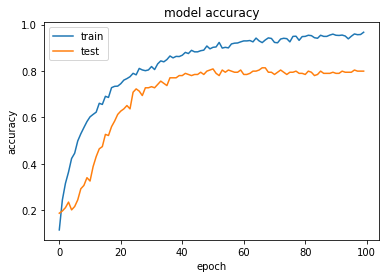

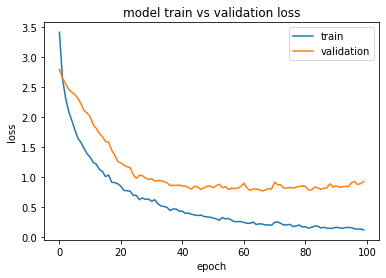

In [30]:
BATCH_SIZE = 64
EPOCHS = 100
dense_layers = [1]
conv_layers = [2]
layer_sizes = [128]

X_train_n = X_train
y_train_n = y_train
X_test_n = X_test
y_test_n = y_test


X_train_n = preprocessing.scale(X_train_n)
X_test_n = preprocessing.scale(X_test_n)

X_train_n = np.reshape(X_train_n, (X_train_n.shape[0], X_train_n.shape[1] , 1))
X_test_n = np.reshape(X_test_n, (X_test_n.shape[0], X_test_n.shape[1], 1))
sw = class_weight.compute_sample_weight('balanced', y_train_n)

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME = f'emotions_cnn-dense-{dense_layer}-layer{layer_size}-conv{conv_layer}-time-{int(time.time())}'
            tb_callback = TensorBoard(log_dir = f'logs/{NAME}')
            
            model2 = Sequential()
            
            if conv_layer > 0:
                model2.add(Conv1D(layer_size, 3,padding='valid', input_shape=(53,1),activation='tanh'))
                model2.add(BatchNormalization())
                model2.add(MaxPooling1D(pool_size=(4)))
                model2.add(Dropout(0.2)) 
                
                for l in range(conv_layer - 1):
                    model2.add(Conv1D(layer_size, 3,padding='valid',activation='tanh'))
                    model2.add(BatchNormalization())
                    model2.add(MaxPooling1D(pool_size=(2)))
                    model2.add(Dropout(0.2)) 
            
                                   
            else:
                model2.add(Flatten())
                model2.add(Dense(layer_size, input_shape = (53,) ,activation='tanh'))
            
            model2.add(Dropout(0.2))  
            model2.add(Flatten())
            for l in range(dense_layer):
                model2.add(Dense(layer_size, activation='relu'))
                model2.add(BatchNormalization())
                model2.add(Dropout(0.1))
                
            model2.add(Dropout(0.3))
            model2.add(Dense(20, activation="softmax"))

            model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

            history = model2.fit(X_train_n, y_train_n, 
                                 batch_size=BATCH_SIZE, 
                                 epochs=EPOCHS,
                                 verbose= 0,
                                 validation_data=(X_test_n, y_test_n),
                                 callbacks = [tb_callback])
            
score = model2.evaluate(X_test_n, y_test_n, verbose=1)

print(f'Loss: {score[0]}\nAccuracy: { round(score[1], 2)*100}%')
y_pred = np.argmax(model2.predict(X_test_n), axis = 1)


cm = metrics.confusion_matrix(y_test_n, y_pred)
f1_score1 = round(f1_score(y_test_n,y_pred,average='micro'),3)

print(f'F1 Score: {f1_score1*100}%\n')
print(f'Confusion Matrix:\n{cm}')
    
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### Results and future work:

Despite not having reached a very high accuracy, it is possible to say that the result was satisfactory in the face of previous works related to this dataset. The method with the best results used the Random Forest algorithm. The result of f1 score was 0.85.
<br/>
<br/>
However, the experience that the dataset provides is not diverse and the model will not have good results without diversity in the data. If the goal is to create an emotion detector in music, it is desirable that more data be collected and that more people act in this process. Since in the creation of this dataset, only three people participated and for such a subjective task it is necessary to include the tastes and feelings of many people.